In [23]:
from ibm_watsonx_ai import APIClient  # Importing IBM Watsonx libraries
from ibm_watsonx_ai import Credentials
from ibm_watsonx_ai.foundation_models import ModelInference
import os, getpass
from langchain_ibm import ChatWatsonx
import config as conf  # Importing configuration file with API credentials

# model_id = "ibm/granite-3-8b-instruct"  # Example model ID (commented out for configurable approach)
model_id = conf.model_id
project_id = conf.project_id
api_key = conf.api_key
service_url = conf.service_url
space_id = None  # Optional parameter for specifying a workspace
verify = False  # Disabling SSL verification (consider enabling in production for security)

prompt = "hello"  # Placeholder prompt for testing API response

# Initialize ChatWatsonx with configured parameters
llm = ChatWatsonx(model_id=model_id, project_id=project_id, url=service_url, apikey=api_key)

# Invoke the model with the test prompt and print the result
result = llm.invoke(prompt)
print(result)  # Consider using logging instead of print for better debugging in production


content='Hello there! How can I assist you today?' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 60, 'total_tokens': 71}, 'model_name': 'ibm/granite-3-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'stop'} id='chatcmpl-7262bed6229c67c5aa0d29de79aca231' usage_metadata={'input_tokens': 60, 'output_tokens': 11, 'total_tokens': 71}


In [24]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    """
    Represents an AI-generated analyst persona with structured attributes.

    Attributes:
        affiliation (str): The primary organization or sector the analyst is associated with.
        name (str): The name of the analyst persona.
        role (str): The specific role or expertise the analyst holds in the given research context.
        description (str): A detailed explanation of the analyst’s focus, concerns, and objectives.

    Methods:
        persona (property): Returns a formatted string representation of the analyst’s details.
    """

    affiliation: str = Field(
        description="Primary affiliation or sector the analyst represents."
    )
    name: str = Field(
        description="Name of the analyst persona."
    )
    role: str = Field(
        description="The analyst’s role or expertise area in the research context."
    )
    description: str = Field(
        description="A brief summary of the analyst’s focus and key concerns."
    )

    @property
    def persona(self) -> str:
        """
        Returns a formatted string representation of the analyst's details.
        """
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    """
    Represents a structured collection of analyst personas.

    Attributes:
        analysts (List[Analyst]): A list containing detailed analyst personas, 
        including their roles, affiliations, and expertise.
    """
    analysts: List[Analyst] = Field(
        description="Detailed list of analysts with their roles and affiliations."
    )

class GenerateAnalystsState(TypedDict):
    """
    Defines the state structure for generating AI analyst personas.

    Attributes:
        topic (str): The research topic for which analysts are generated.
        max_analysts (int): The maximum number of analyst personas to generate.
        human_analyst_feedback (str): Optional feedback from users to refine the generated personas.
        analysts (List[Analyst]): The list of AI-generated analyst personas.
    """
    topic: str  # Research topic for which analysts are being created
    max_analysts: int  # Maximum number of analysts to generate
    human_analyst_feedback: str  # Feedback provided by users for refining personas
    analysts: List[Analyst]  # List of generated analyst personas


In [25]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""As an expert AI Policy & Governance Specialist or AI Ethnographer, you are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic from AI Governance or planning perspective:
{topic}
        
2. Examine any superior feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes/topics based feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [26]:
def create_analysts(state: GenerateAnalystsState):
    """
    Generates AI analyst personas based on a given research topic and optional human feedback.

    Steps:
    1. Extracts the topic, maximum number of analysts, and any user-provided feedback from the state.
    2. Utilizes IBM watsonx.ai with structured output enforcement to ensure well-defined persona generation.
    3. Constructs a system message guiding the AI on how to create relevant analyst personas.
    4. Invokes the AI model to generate a structured list of analysts based on the topic and instructions.
    5. Returns the generated analyst personas as part of the updated state.

    Args:
        state (GenerateAnalystsState): The current state containing topic details, max analysts, and feedback.

    Returns:
        dict: A dictionary containing the list of generated analyst personas.
    """

    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get('human_analyst_feedback', '')

    # Enforce structured output format for analyst personas
    structured_llm = llm.with_structured_output(Perspectives)

    # Construct system message with topic, feedback, and max analysts
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts
    )

    # Generate analyst personas using AI
    analysts = structured_llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content="Generate the set of analysts.")
    ])

    # Return the generated analyst personas as part of the updated state
    return {"analysts": analysts.analysts}


In [27]:
def human_feedback(state: GenerateAnalystsState):
    """ 
    Placeholder function representing a human feedback node in the workflow. 
    This function is intentionally left empty as it serves as an interruption 
    point where user feedback is collected before resuming persona generation.
    """
    pass


In [28]:
def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

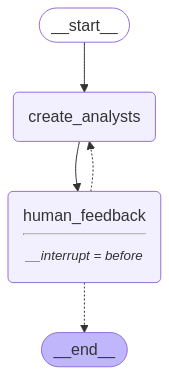

In [29]:
# Initialize the state graph with the defined GenerateAnalystsState structure
builder = StateGraph(GenerateAnalystsState)

# Add a node to generate AI analyst personas
builder.add_node("create_analysts", create_analysts)

# Add a node to allow human feedback for refining the generated personas
builder.add_node("human_feedback", human_feedback)

# Define the workflow: Start by creating analysts, then proceed to human feedback
builder.add_edge(START, "create_analysts")

# After generating analysts, move to the human feedback stage
builder.add_edge("create_analysts", "human_feedback")

# Based on feedback, either regenerate analysts or conclude the process
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile the state graph with a memory checkpoint for tracking progress
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# Generate and display a visualization of the workflow for better understanding
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [30]:
# Define the maximum number of AI analyst personas to generate
max_analysts = 3  

# Specify the research topic for which AI-generated analyst personas will be created
topic = "The benefits of adopting data trust and governance framework and its advantages in Generative AI"

# Initialize a thread configuration to track execution and responses
thread = {"configurable": {"thread_id": "1"}}

In [31]:
# Execute the AI persona generation graph until the first interruption point
for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    
    # Retrieve the generated analysts from the event output
    analysts = event.get("analysts", '')

    # If analysts are generated, print their details
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 5)  # Separator for readability 

Name: Dr. Emily Stanton
Affiliation: Technology Law & Policy Center
Role: Data Trust Governance Specialist
Description: The Data Trust Governance Explorer is a seasoned lawyer and policy specialist who has dedicated her career to navigating the legal complexities surrounding data trusts and governance frameworks. Her expertise lies in identifying potential regulatory and ethical challenges and proposing tailored solutions that ensure data trusts can thrive while respecting user rights and legal standards. Her research will focus on how data trusts can effectively govern Generative AI technologies without compromising on data privacy, security, and ethics.
-----
Name: Dr. Alex Deveraux
Affiliation: AI Ethics Institute
Role: AI Ethnographer
Description: AI Ethnographer Dr. Alex Deveraux specializes in understanding and analyzing the societal, cultural, and ethical implications of Generative AI. As an expert in AI ethnology, he explores the ways in which these technologies shape and are s

In [32]:
state=graph.get_state(thread)

In [33]:
state.next

('human_feedback',)

In [34]:
# Simulating human feedback by updating the AI system's state 
# Here, we add a government as well as NGO representative's perspective to enhance diversity in personas
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a Government organization as well as NGO representative to add their perspective"}, 
                   as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00c8d6-dc87-6e06-8002-3fb08d7e6e40'}}

In [35]:
# Continue executing the graph workflow to process any remaining steps
for event in graph.stream(None, thread, stream_mode="values"):
    
    # Retrieve the updated list of analysts from the event output
    analysts = event.get('analysts', '')

    # If analysts are available, print their details for review
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 5)  # Separator for better readability

Name: Dr. Emily Stanton
Affiliation: Technology Law & Policy Center
Role: Data Trust Governance Specialist
Description: The Data Trust Governance Explorer is a seasoned lawyer and policy specialist who has dedicated her career to navigating the legal complexities surrounding data trusts and governance frameworks. Her expertise lies in identifying potential regulatory and ethical challenges and proposing tailored solutions that ensure data trusts can thrive while respecting user rights and legal standards. Her research will focus on how data trusts can effectively govern Generative AI technologies without compromising on data privacy, security, and ethics.
-----
Name: Dr. Alex Deveraux
Affiliation: AI Ethics Institute
Role: AI Ethnographer
Description: AI Ethnographer Dr. Alex Deveraux specializes in understanding and analyzing the societal, cultural, and ethical implications of Generative AI. As an expert in AI ethnology, he explores the ways in which these technologies shape and are s

In [19]:
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00c8b3-ebec-681c-8007-e75360ed5211'}}

In [20]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [21]:
# Retrieve the final state of the AI workflow after persona generation
# This state contains the latest version of the generated analysts, incorporating all refinements
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')  # Extract the list of generated analyst personas

In [22]:
final_state.next

()